In [1]:
################################################################
#              Aknowledgements                                 #
################################################################
# This notebook takes inspriration from the following work    #
# of kaggle user Black Mamba                                  #
# https://www.kaggle.com/theblackmamba31/who-is-behind-the-mask
#                                                             #
# do upvote her work                                          #
###############################################################


###############################################################
#  This noteBook contains a Transformer for image Segmentation#
###############################################################

In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
tf.__version__

'2.10.0'

In [3]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj
        
    
 
    
   

In [4]:
framObjTrain = LoadData( framObjTrain, imgPath = 'CamVid/train', maskPath = 'CamVid/train_labels'
         , shape = 256)

In [5]:
framObjValidation  = LoadData( framObjValidation, imgPath = 'CamVid/val', maskPath = 'CamVid/val_labels'
         , shape = 256)

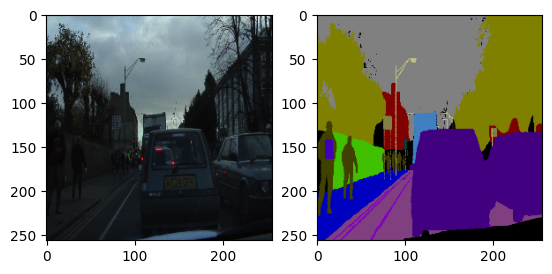

In [6]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [18]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)    
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [19]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Unet_baseline",
        save_best_only=True,
        monitor="val_loss")
]


In [20]:
## trainign our model
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 150,validation_data=(np.array(framObjValidation['img']),np.array(framObjValidation['mask'])),callbacks=callbacks)

Epoch 1/150
12/12 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.5718INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 21s 2s/step - loss: 0.7057 - accuracy: 0.5718 - val_loss: 22.0570 - val_accuracy: 0.2750
Epoch 2/150
12/12 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.5527INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.6334 - accuracy: 0.5527 - val_loss: 14.8925 - val_accuracy: 0.0346
Epoch 3/150
12/12 [==============================] - 5s 407ms/step - loss: 0.5989 - accuracy: 0.5206 - val_loss: 28.2606 - val_accuracy: 0.2155
Epoch 4/150
12/12 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.5186INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5802 - accuracy: 0.5186 - val_loss: 12.4308 - val_accuracy: 0.1635
Epoch 5/150
12/12 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.4901INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 14s 1s/step - loss: 0.5731 - accuracy: 0.4901 - val_loss: 1.6308 - val_accuracy: 0.3734
Epoch 6/150
12/12 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.4885INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 18s 2s/step - loss: 0.5664 - accuracy: 0.4885 - val_loss: 0.9025 - val_accuracy: 0.4101
Epoch 7/150
12/12 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.4739INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5621 - accuracy: 0.4739 - val_loss: 0.7860 - val_accuracy: 0.6572
Epoch 8/150
12/12 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.4755INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 16s 1s/step - loss: 0.5569 - accuracy: 0.4755 - val_loss: 0.7100 - val_accuracy: 0.6872
Epoch 9/150
12/12 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.5420INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 16s 1s/step - loss: 0.5515 - accuracy: 0.5420 - val_loss: 0.6804 - val_accuracy: 0.6697
Epoch 10/150
12/12 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.6024INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 16s 1s/step - loss: 0.5486 - accuracy: 0.6024 - val_loss: 0.6610 - val_accuracy: 0.6739
Epoch 11/150
12/12 [==============================] - 5s 413ms/step - loss: 0.5464 - accuracy: 0.5871 - val_loss: 0.6655 - val_accuracy: 0.6644
Epoch 12/150
12/12 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.5651INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5423 - accuracy: 0.5651 - val_loss: 0.6431 - val_accuracy: 0.6576
Epoch 13/150
12/12 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.5771INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5396 - accuracy: 0.5771 - val_loss: 0.6411 - val_accuracy: 0.6371
Epoch 14/150
12/12 [==============================] - 5s 405ms/step - loss: 0.5369 - accuracy: 0.5732 - val_loss: 0.6467 - val_accuracy: 0.5550
Epoch 15/150
12/12 [==============================] - 5s 436ms/step - loss: 0.5361 - accuracy: 0.5776 - val_loss: 0.6417 - val_accuracy: 0.5945
Epoch 16/150
12/12 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.5804INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5337 - accuracy: 0.5804 - val_loss: 0.6351 - val_accuracy: 0.5520
Epoch 17/150
12/12 [==============================] - 5s 439ms/step - loss: 0.5311 - accuracy: 0.5624 - val_loss: 0.6357 - val_accuracy: 0.4759
Epoch 18/150
12/12 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.5923INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5307 - accuracy: 0.5923 - val_loss: 0.6309 - val_accuracy: 0.5664
Epoch 19/150
12/12 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.5888INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5310 - accuracy: 0.5888 - val_loss: 0.6172 - val_accuracy: 0.6105
Epoch 20/150
12/12 [==============================] - 5s 432ms/step - loss: 0.5290 - accuracy: 0.5683 - val_loss: 0.6357 - val_accuracy: 0.5628
Epoch 21/150
12/12 [==============================] - 5s 438ms/step - loss: 0.5264 - accuracy: 0.6114 - val_loss: 0.6330 - val_accuracy: 0.5838
Epoch 22/150
12/12 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.5619INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5243 - accuracy: 0.5619 - val_loss: 0.6020 - val_accuracy: 0.6417
Epoch 23/150
12/12 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.5857INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 16s 1s/step - loss: 0.5236 - accuracy: 0.5857 - val_loss: 0.6000 - val_accuracy: 0.6288
Epoch 24/150
12/12 [==============================] - 5s 405ms/step - loss: 0.5238 - accuracy: 0.6059 - val_loss: 0.6073 - val_accuracy: 0.6597
Epoch 25/150
12/12 [==============================] - 5s 413ms/step - loss: 0.5281 - accuracy: 0.5691 - val_loss: 0.6303 - val_accuracy: 0.5372
Epoch 26/150
12/12 [==============================] - 5s 411ms/step - loss: 0.5246 - accuracy: 0.5802 - val_loss: 0.6268 - val_accuracy: 0.5489
Epoch 27/150
12/12 [==============================] - 5s 411ms/step - loss: 0.5225 - accuracy: 0.6014 - val_loss: 0.6374 - val_accuracy: 0.3155
Epoch 28/150
12/12 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.5782INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5226 - accuracy: 0.5782 - val_loss: 0.5688 - val_accuracy: 0.5351
Epoch 29/150
12/12 [==============================] - 5s 417ms/step - loss: 0.5212 - accuracy: 0.6034 - val_loss: 0.5777 - val_accuracy: 0.5673
Epoch 30/150
12/12 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.5953INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5195 - accuracy: 0.5953 - val_loss: 0.5559 - val_accuracy: 0.7192
Epoch 31/150
12/12 [==============================] - ETA: 0s - loss: 0.5177 - accuracy: 0.5990INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5177 - accuracy: 0.5990 - val_loss: 0.5557 - val_accuracy: 0.6515
Epoch 32/150
12/12 [==============================] - 5s 403ms/step - loss: 0.5164 - accuracy: 0.6079 - val_loss: 0.5558 - val_accuracy: 0.5145
Epoch 33/150
12/12 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.6060INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5160 - accuracy: 0.6060 - val_loss: 0.5500 - val_accuracy: 0.7095
Epoch 34/150
12/12 [==============================] - 5s 408ms/step - loss: 0.5164 - accuracy: 0.6155 - val_loss: 0.5651 - val_accuracy: 0.4976
Epoch 35/150
12/12 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.6046INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 16s 1s/step - loss: 0.5144 - accuracy: 0.6046 - val_loss: 0.5482 - val_accuracy: 0.6405
Epoch 36/150
12/12 [==============================] - 5s 402ms/step - loss: 0.5142 - accuracy: 0.6208 - val_loss: 0.5537 - val_accuracy: 0.5819
Epoch 37/150
12/12 [==============================] - 5s 403ms/step - loss: 0.5133 - accuracy: 0.6179 - val_loss: 0.5543 - val_accuracy: 0.6708
Epoch 38/150
12/12 [==============================] - 5s 404ms/step - loss: 0.5134 - accuracy: 0.6386 - val_loss: 0.5568 - val_accuracy: 0.5964
Epoch 39/150
12/12 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.6358INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5124 - accuracy: 0.6358 - val_loss: 0.5428 - val_accuracy: 0.6148
Epoch 40/150
12/12 [==============================] - 5s 404ms/step - loss: 0.5111 - accuracy: 0.6315 - val_loss: 0.5586 - val_accuracy: 0.5736
Epoch 41/150
12/12 [==============================] - 5s 405ms/step - loss: 0.5116 - accuracy: 0.6391 - val_loss: 0.5660 - val_accuracy: 0.5758
Epoch 42/150
12/12 [==============================] - 5s 401ms/step - loss: 0.5110 - accuracy: 0.6437 - val_loss: 0.5550 - val_accuracy: 0.5663
Epoch 43/150
12/12 [==============================] - 5s 409ms/step - loss: 0.5098 - accuracy: 0.6637 - val_loss: 0.5450 - val_accuracy: 0.5799
Epoch 44/150
12/12 [==============================] - 5s 401ms/step - loss: 0.5092 - accuracy: 0.6340 - val_loss: 0.5525 - val_accuracy: 0.6187
Epoch 45/150
12/12 [==============================] - 5s 401ms/step - loss: 0.5079 - accuracy: 0.6534 - val_loss: 0.5549 - val_accuracy: 0.5508
Epoch 4

INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5055 - accuracy: 0.6699 - val_loss: 0.5326 - val_accuracy: 0.5397
Epoch 53/150
12/12 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.6509INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5051 - accuracy: 0.6509 - val_loss: 0.5308 - val_accuracy: 0.5899
Epoch 54/150
12/12 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.6706INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5048 - accuracy: 0.6706 - val_loss: 0.5306 - val_accuracy: 0.5794
Epoch 55/150
12/12 [==============================] - 5s 402ms/step - loss: 0.5037 - accuracy: 0.6501 - val_loss: 0.5333 - val_accuracy: 0.5571
Epoch 56/150
12/12 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.6917INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5027 - accuracy: 0.6917 - val_loss: 0.5301 - val_accuracy: 0.5864
Epoch 57/150
12/12 [==============================] - 5s 402ms/step - loss: 0.5032 - accuracy: 0.6468 - val_loss: 0.5314 - val_accuracy: 0.6022
Epoch 58/150
12/12 [==============================] - 5s 404ms/step - loss: 0.5033 - accuracy: 0.6935 - val_loss: 0.5327 - val_accuracy: 0.5749
Epoch 59/150
12/12 [==============================] - 5s 401ms/step - loss: 0.5031 - accuracy: 0.6560 - val_loss: 0.5505 - val_accuracy: 0.6011
Epoch 60/150
12/12 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.6734INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5023 - accuracy: 0.6734 - val_loss: 0.5301 - val_accuracy: 0.5748
Epoch 61/150
12/12 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.6774INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5015 - accuracy: 0.6774 - val_loss: 0.5287 - val_accuracy: 0.5927
Epoch 62/150
12/12 [==============================] - 5s 441ms/step - loss: 0.5010 - accuracy: 0.6827 - val_loss: 0.5313 - val_accuracy: 0.5936
Epoch 63/150
12/12 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.6593INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5007 - accuracy: 0.6593 - val_loss: 0.5283 - val_accuracy: 0.6518
Epoch 64/150
12/12 [==============================] - 5s 403ms/step - loss: 0.5003 - accuracy: 0.6970 - val_loss: 0.5296 - val_accuracy: 0.6217
Epoch 65/150
12/12 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.6707INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5007 - accuracy: 0.6707 - val_loss: 0.5283 - val_accuracy: 0.5923
Epoch 66/150
12/12 [==============================] - 5s 422ms/step - loss: 0.5002 - accuracy: 0.6734 - val_loss: 0.5304 - val_accuracy: 0.5752
Epoch 67/150
12/12 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.7016INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4998 - accuracy: 0.7016 - val_loss: 0.5272 - val_accuracy: 0.5726
Epoch 68/150
12/12 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.6575INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4988 - accuracy: 0.6575 - val_loss: 0.5269 - val_accuracy: 0.5770
Epoch 69/150
12/12 [==============================] - 5s 401ms/step - loss: 0.4984 - accuracy: 0.6661 - val_loss: 0.5278 - val_accuracy: 0.5746
Epoch 70/150
12/12 [==============================] - 5s 400ms/step - loss: 0.4979 - accuracy: 0.6968 - val_loss: 0.5286 - val_accuracy: 0.5921
Epoch 71/150
12/12 [==============================] - 5s 401ms/step - loss: 0.4985 - accuracy: 0.6630 - val_loss: 0.5273 - val_accuracy: 0.6059
Epoch 72/150
12/12 [==============================] - 5s 398ms/step - loss: 0.4980 - accuracy: 0.6705 - val_loss: 0.5307 - val_accuracy: 0.5652
Epoch 73/150
12/12 [==============================] - 5s 399ms/step - loss: 0.4985 - accuracy: 0.6848 - val_loss: 0.5315 - val_accuracy: 0.6130
Epoch 74/150
12/12 [==============================] - ETA: 0s - loss: 0.4978 - accuracy: 0.6899INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4978 - accuracy: 0.6899 - val_loss: 0.5258 - val_accuracy: 0.6753
Epoch 75/150
12/12 [==============================] - 5s 409ms/step - loss: 0.4979 - accuracy: 0.6821 - val_loss: 0.5297 - val_accuracy: 0.6018
Epoch 76/150
12/12 [==============================] - 5s 400ms/step - loss: 0.4973 - accuracy: 0.6672 - val_loss: 0.5324 - val_accuracy: 0.5935
Epoch 77/150
12/12 [==============================] - 5s 398ms/step - loss: 0.4974 - accuracy: 0.6862 - val_loss: 0.5298 - val_accuracy: 0.6133
Epoch 78/150
12/12 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.6930INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4973 - accuracy: 0.6930 - val_loss: 0.5248 - val_accuracy: 0.6501
Epoch 79/150
12/12 [==============================] - 5s 399ms/step - loss: 0.4970 - accuracy: 0.6647 - val_loss: 0.5303 - val_accuracy: 0.6006
Epoch 80/150
12/12 [==============================] - 5s 401ms/step - loss: 0.4970 - accuracy: 0.6996 - val_loss: 0.5297 - val_accuracy: 0.6170
Epoch 81/150
12/12 [==============================] - 5s 401ms/step - loss: 0.4961 - accuracy: 0.6832 - val_loss: 0.5266 - val_accuracy: 0.6073
Epoch 82/150
12/12 [==============================] - 5s 400ms/step - loss: 0.4966 - accuracy: 0.6636 - val_loss: 0.5292 - val_accuracy: 0.6421
Epoch 83/150
12/12 [==============================] - 5s 399ms/step - loss: 0.4974 - accuracy: 0.6903 - val_loss: 0.5298 - val_accuracy: 0.6275
Epoch 84/150
12/12 [==============================] - 5s 399ms/step - loss: 0.4990 - accuracy: 0.6742 - val_loss: 0.5310 - val_accuracy: 0.6603
Epoch 8

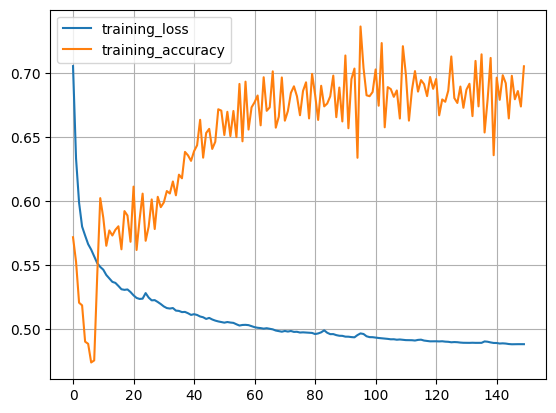

In [21]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

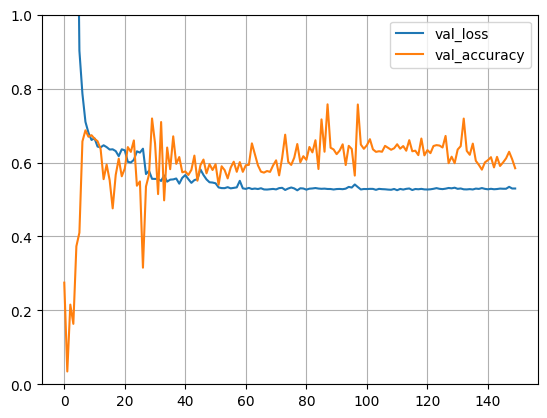

In [23]:
plt.plot(retVal.history['val_loss'], label = 'val_loss')
plt.plot(retVal.history['val_accuracy'], label = 'val_accuracy')
plt.ylim((0,1))
plt.legend()
plt.grid(True)

In [6]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')
    
    
    
    

In [25]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)

4/4 [==============================] - 2s 88ms/step


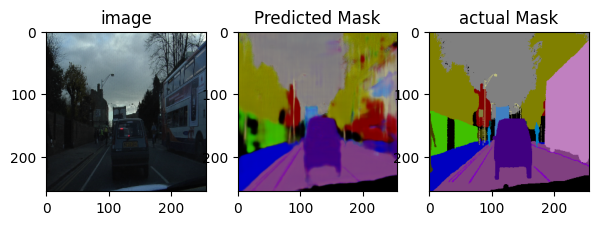

In [26]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

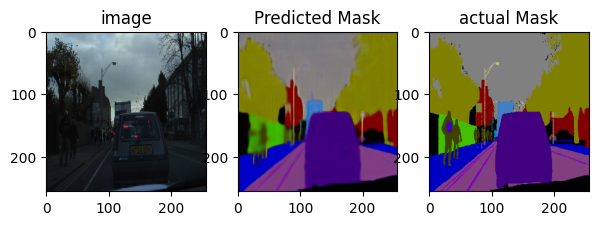

In [27]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

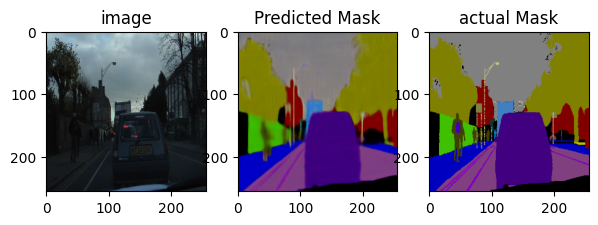

In [28]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

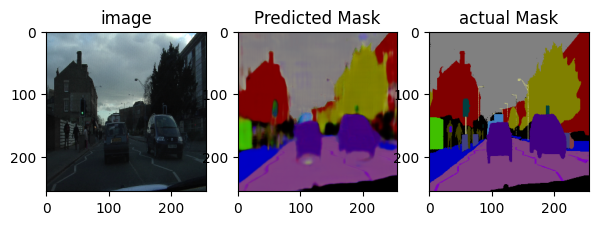

In [29]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

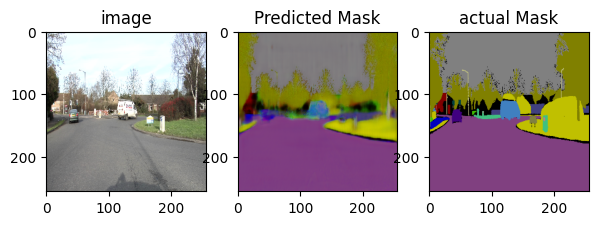

In [30]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

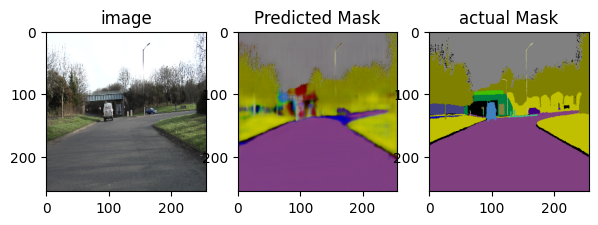

In [31]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

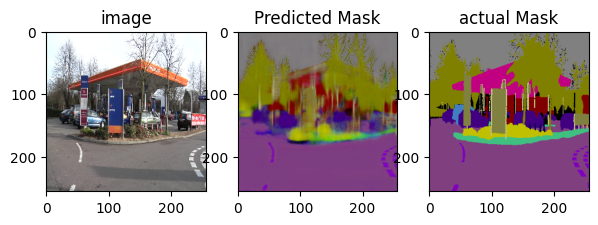

In [32]:
Plotter(actuals[14], sixteenPrediction[14], masks[14])

## prediction and IOU score

In [7]:
from tensorflow import keras
model = tf.keras.models.load_model('Unet_baseline')


In [8]:
def predictAll (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    #mask = mask[0:16]
    
    #imgProc = img [0:16]
    imgProc = np.array(img)
    mask = np.array(mask)
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
        
    return predictions, imgProc, mask

In [9]:
label = pd.read_csv('CamVid/class_dict.csv',usecols=[1,2,3])
label = label.to_numpy().reshape((32,3))
def RGBtolabel(RGB,label) :
    number = np.linalg.norm(RGB - label,axis=1).argmin()
    return number


In [10]:
Prediction, actuals, masks = predictAll(framObjValidation, model)
Prediction = Prediction*255
masks = masks*255

4/4 [==============================] - 20s 204ms/step


In [11]:
#get label for all pixels
predicted_label_list = []
true_label_list = []
for k in range(100) : #img #
    for i in range(256) : 
        for j in range(256) : #get rgb pixels
            predicted_label_list.append(RGBtolabel(Prediction[k][i][j],label))
            true_label_list.append(RGBtolabel(masks[k][i][j],label))



In [17]:
from sklearn import metrics
from sklearn.metrics import classification_report
y_true = true_label_list
y_pred = predicted_label_list



In [21]:
iou_score_list = []
for i in range(32) :
    m = tf.keras.metrics.IoU(num_classes=32, target_class_ids=[i])
    m.update_state(y_pred=y_pred,y_true=y_true)
    iou_score_list.append( m.result().numpy())


In [16]:
class_name = pd.read_csv('CamVid/class_dict.csv',usecols=[0])
class_name

,name
0,Animal
1,Archway
2,Bicyclist
3,Bridge
4,Building
5,Car
6,CartLuggagePram
7,Child
8,Column_Pole
9,Fence


In [17]:
iou_score_list

[0.006949365,
 0.0,
 0.41052046,
 0.015120967,
 0.8240546,
 0.63537467,
 0.018651534,
 0.0,
 8.520065e-05,
 0.24401046,
 0.42845106,
 0.0,
 0.06847083,
 0.0,
 0.06405085,
 0.043114275,
 0.057989918,
 0.898459,
 0.0,
 0.80374897,
 0.0,
 0.8538631,
 0.19765322,
 0.0051087085,
 0.16828315,
 0.0,
 0.7073088,
 0.0,
 0.012700491,
 0.37002113,
 0.17105614,
 0.43813583]

In [22]:
class_name['iou_score'] = iou_score_list

In [24]:
class_name.to_excel('iou_score_unet_baseline.xlsx')

## classification report

In [23]:
class_report = classification_report(y_true=y_true,y_pred=y_pred)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [25]:
print(class_report)

              precision    recall  f1-score   support

           0       0.01      0.03      0.01      8124
           1       0.00      0.00      0.00     14534
           2       0.92      0.43      0.58     31137
           3       0.03      0.03      0.03      1791
           4       0.92      0.89      0.90   1461737
           5       0.78      0.78      0.78    237769
           6       0.02      0.10      0.04      4592
           7       0.00      0.00      0.00      4554
           8       0.56      0.00      0.00     58681
           9       0.33      0.48      0.39     86465
          10       0.72      0.51      0.60    111325
          11       0.00      0.00      0.00      3231
          12       0.09      0.26      0.13     55250
          13       0.00      0.00      0.00       398
          14       0.07      0.39      0.12     33600
          15       0.42      0.05      0.08     15710
          16       0.08      0.17      0.11     50326
          17       0.93    